In [145]:
# importing the necessary library
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import shutil
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [146]:
# seting path to the dataset

# Set the base directory where the train and test data folders are located
base_directory = "C:/Users/ashka/Desktop/lab10/archive (2)"

# Define the subdirectories for train and test data
train_data= os.path.join(base_directory, "train")
test_data = os.path.join(base_directory, "test")
valid_data = os.path.join(base_directory, "valid")

img_count = {}
# finding the top 3 classes
for species in os.listdir(train_data):
    path_species = os.path.join(train_data, species)
    if os.path.isdir(path_species):
        img_count[species] = len(os.listdir(path_species))
        
top_classes = sorted(img_count, key=img_count.get, reverse=True)[:3]
print("Top 3 classes with highest number of images:", top_classes)

Top 3 classes with highest number of images: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [147]:
top_3_class = ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']

def remove_folder(dir_path):
    for entry in os.scandir(dir_path):
        if entry.is_file():
            os.remove(entry.path)
        elif entry.is_dir() and entry.name not in top_3_class:
            # recursively call the function to remove the files inside
            remove_folder(entry.path)
            # remove empty folder after removing files
            os.rmdir(entry.path)

# Paths to the directories
train_path = "C://Users//ashka//Desktop//lab10//archive (2)//train"
test_path = "C://Users//ashka//Desktop//lab10//archive (2)//test"
validation_path = "C://Users//ashka//Desktop//lab10//archive (2)//valid"

# Call the function for three folders
remove_folder(train_path)
remove_folder(test_path)
remove_folder(validation_path)

In [148]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(train_path, image_size=(224,224), batch_size=32)
validation_data = image_dataset_from_directory(validation_path, image_size=(224,224), batch_size=32)
test_data = image_dataset_from_directory(test_path, image_size=(224,224), batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


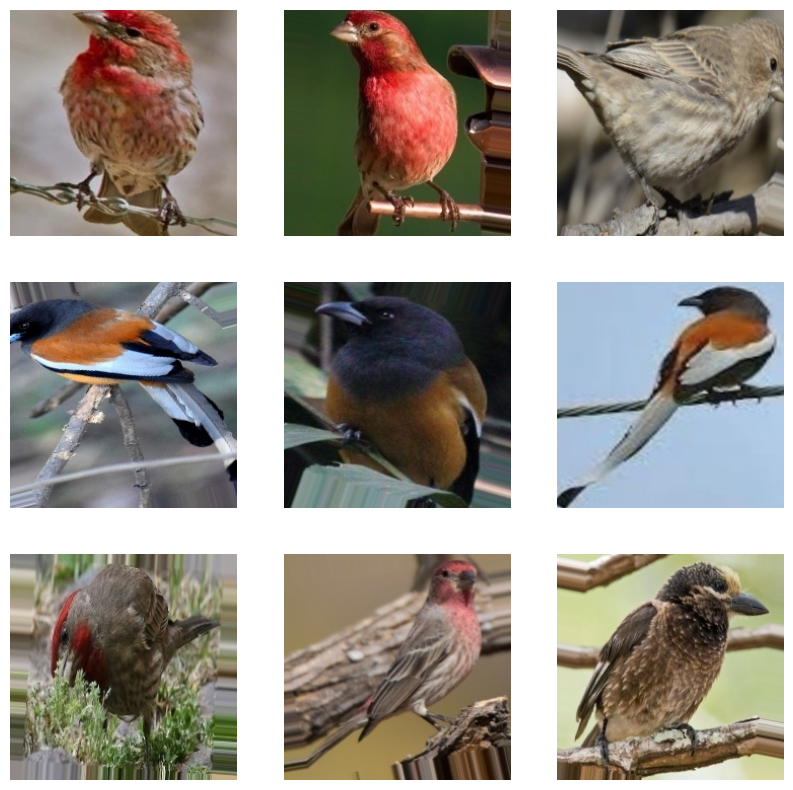

In [149]:
#from keras.preprocessing.image import ImageDataGenerator

augmented_data = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

validation_data_generator = ImageDataGenerator(rescale = 1.0/255)

train_generator = augmented_data.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = augmented_data.flow_from_directory(
    validation_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# display some augmented training images

# get images and labels from train_generator
images, _ = next(train_generator)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
plt.show()

In [150]:
# load pre-trained VGG16 model from imagenet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [151]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)


predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [152]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [153]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [154]:
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])


In [155]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
24/24 [==============================] - 47s 2s/step - loss: 1.2710 - accuracy: 0.8293 - val_loss: 1.5525e-04 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 54s 2s/step - loss: 0.3269 - accuracy: 0.9543 - val_loss: 1.2104e-04 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 52s 2s/step - loss: 0.2081 - accuracy: 0.9704 - val_loss: 1.2557e-06 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 50s 2s/step - loss: 0.1475 - accuracy: 0.9798 - val_loss: 1.9868e-07 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 49s 2s/step - loss: 0.1771 - accuracy: 0.9758 - val_loss: 0.0155 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 49s 2s/step - loss: 0.0658 - accuracy: 0.9785 - val_loss: 0.0329 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 49s 2s/step - loss: 0.1636 - accuracy: 0.9785 - val_loss: 0.1671 - val_accuracy: 0.9333
Epoc

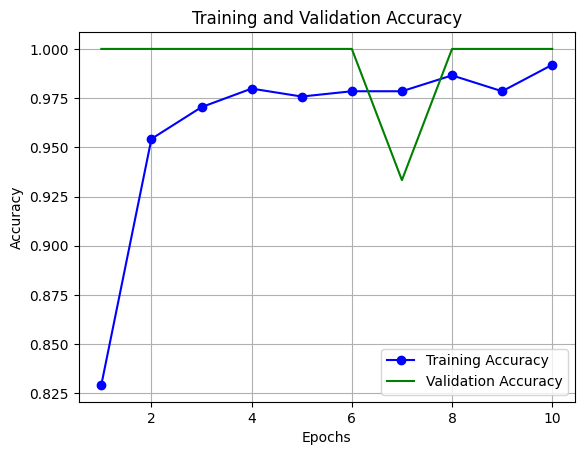

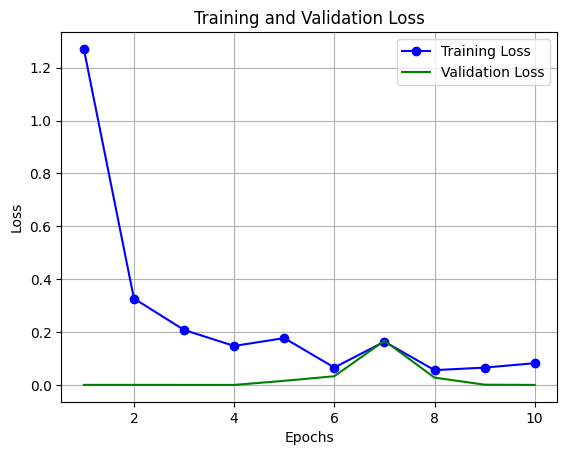

In [156]:
import matplotlib.pyplot as plt

# Rename variables for clarity
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(train_accuracy) + 1)

# Plotting training and validation accuracy
plt.plot(epochs, train_accuracy, "b-o", label="Training Accuracy")  # Blue line with circles
plt.plot(epochs, val_accuracy, "g-", label="Validation Accuracy")  # Green solid line
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation loss
plt.plot(epochs, train_loss, "b-o", label="Training Loss")  # Blue line with circles
plt.plot(epochs, val_loss, "g-", label="Validation Loss")  # Green solid line
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [157]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 1s 835ms/step - loss: 9.7303e-04 - accuracy: 1.0000
Test accuracy: 1.000


In [158]:
# Step 1: Predict classes using the model on the validation data
y_pred = model.predict(validation_generator)

# Step 2: Convert the probability predictions to class labels by selecting the class with the highest probability
y_pred_class = np.argmax(y_pred, axis=1)

# Step 3: Get the true class labels from the validation generator
y_true = validation_generator.classes

# Step 4: Compute the confusion matrix to evaluate the model's performance
cm = confusion_matrix(y_true, y_pred_class)

# Step 5: Print a classification report to get more detailed evaluation metrics like precision, recall, and F1-score
# The `target_names` argument is used to map class indices to their respective class labels in the report.
print(classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys()))


1/1 [==============================] - 1s 1s/step
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.00      0.00      0.00         5
     HOUSE FINCH       0.20      0.20      0.20         5
    RUFOUS TREPE       0.20      0.20      0.20         5

        accuracy                           0.13        15
       macro avg       0.13      0.13      0.13        15
    weighted avg       0.13      0.13      0.13        15



1/1 [==============================] - 1s 867ms/step


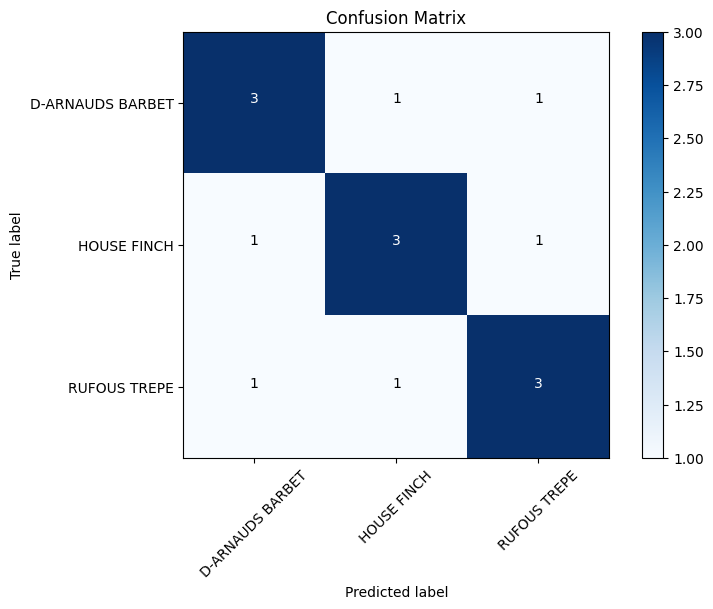

Classification Report:
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.60      0.60      0.60         5
     HOUSE FINCH       0.60      0.60      0.60         5
    RUFOUS TREPE       0.60      0.60      0.60         5

        accuracy                           0.60        15
       macro avg       0.60      0.60      0.60        15
    weighted avg       0.60      0.60      0.60        15



In [159]:


# Replace these with your actual model predictions and true labels
y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys())

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    thresh = conf_matrix.max() / 2.0
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(conf_matrix, classes=validation_generator.class_indices.keys(), title='Confusion Matrix')

# Display precision, recall, and F1-score
print("Classification Report:")
print(classification_rep)
